# Improved Monte Carlo simulation for 4 years

This notebook performs an improved Monte Carlo simulation to generate, analyze and reduce global radiation scenarios. Seasonal effects (monthly/yearly) are also considered.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.cluster import KMeans

## 1. loading and preparing the data

In this step, the CSV file is loaded and the timestamp is parsed. The columns are also renamed and additional columns are created for seasonal analysis.

In [23]:
def read_and_prepare_dataset(dataset_path):
    df = pd.read_csv(dataset_path)
    df['time'] = pd.to_datetime(df['time'], format='%Y%m%d:%H%M')

    # Umbenennung der Spalten
    df = df.rename(columns={
        "G(i) (Globalstrahlung)": "global_radiation",
        "H_sun (Sonnenscheindauer in min)": "sunshine_duration",
        "T2m (Temperatur)": "temperature",
        "WS10m (Windgeschwindigkeit)": "wind_speed"
    })

    # Monatliche Gruppierung zur Analyse von Saisonalität
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month

    return df

# Passe den Pfad zur CSV-Datei an
df = read_and_prepare_dataset('Timeseries_2020_2023.csv')

# Zeige die ersten Zeilen an
df.head()

,time,global_radiation,sunshine_duration,temperature,wind_speed,year,month
0,2022-01-01 00:10:00,0.0,0.0,11.92,3.24,2022,1
1,2022-01-01 01:10:00,0.0,0.0,11.73,2.90,2022,1
2,2022-01-01 02:10:00,0.0,0.0,11.74,2.62,2022,1
3,2022-01-01 03:10:00,0.0,0.0,11.44,2.48,2022,1
4,2022-01-01 04:10:00,0.0,0.0,11.30,2.41,2022,1


## 2. calculation and presentation of the PDF

Here a Kernel Density Estimation (KDE) is used to calculate and visualize the probability density function (PDF) of the global radiation.

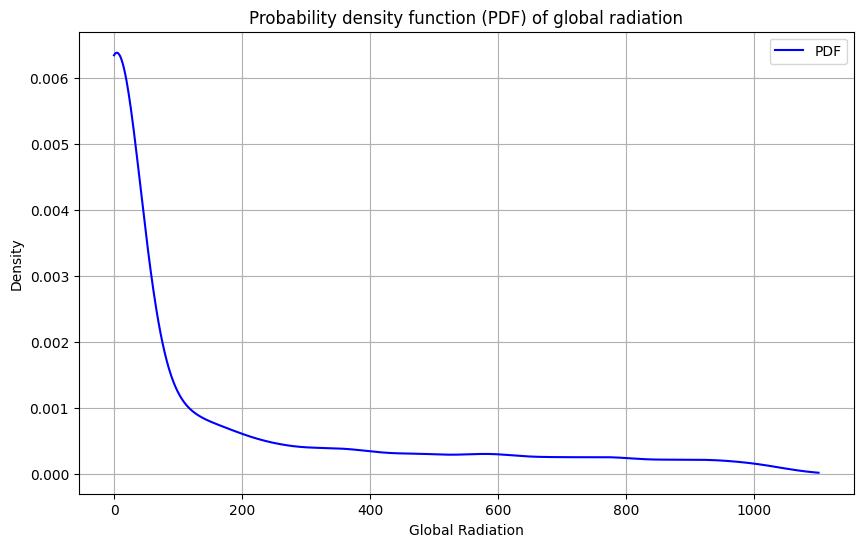

In [24]:
# Extrahiere die global_radiation-Daten
data = df['global_radiation'].values

# Berechne die KDE
kde = stats.gaussian_kde(data)
x_values = np.linspace(np.min(data), np.max(data), 1000)
pdf_values = kde(x_values)

plt.figure(figsize=(10, 6))
plt.plot(x_values, pdf_values, label='PDF', color='blue')
plt.title('Probability density function (PDF) of global radiation')
plt.xlabel('Global Radiation')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

## 3. presentation of the empirical CDF

The empirical cumulative distribution function (CDF) is calculated by sorting the data and determining the cumulative probabilities.

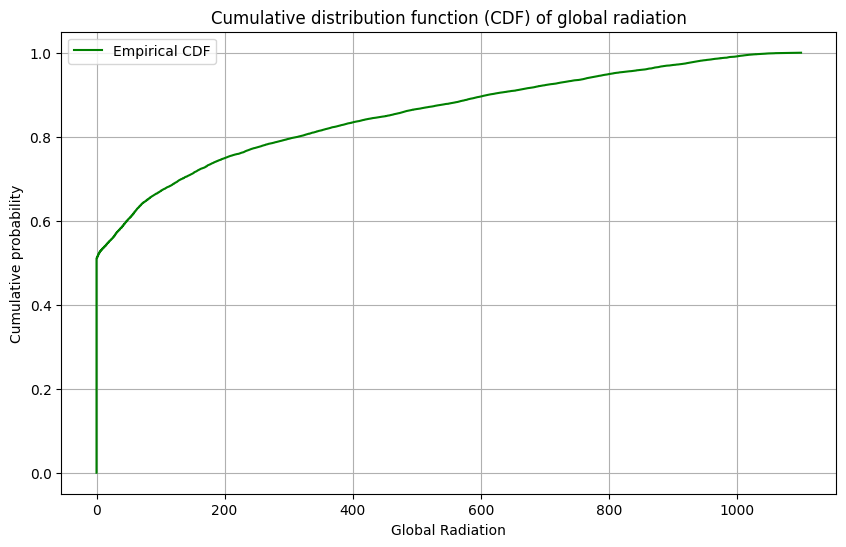

In [25]:
# Sortiere die Daten und berechne die empirische CDF
sorted_data = np.sort(data)
cdf_values = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

plt.figure(figsize=(10, 6))
plt.plot(sorted_data, cdf_values, label='Empirical CDF', color='green')
plt.title('Cumulative distribution function (CDF) of global radiation')
plt.xlabel('Global Radiation')
plt.ylabel('Cumulative probability')
plt.legend()
plt.grid(True)
plt.show()

## 4. Monte Carlo scenario generation using inverse CDF

Monte Carlo scenarios are generated here by interpolating the inverse of the empirical CDF for equally distributed random numbers.

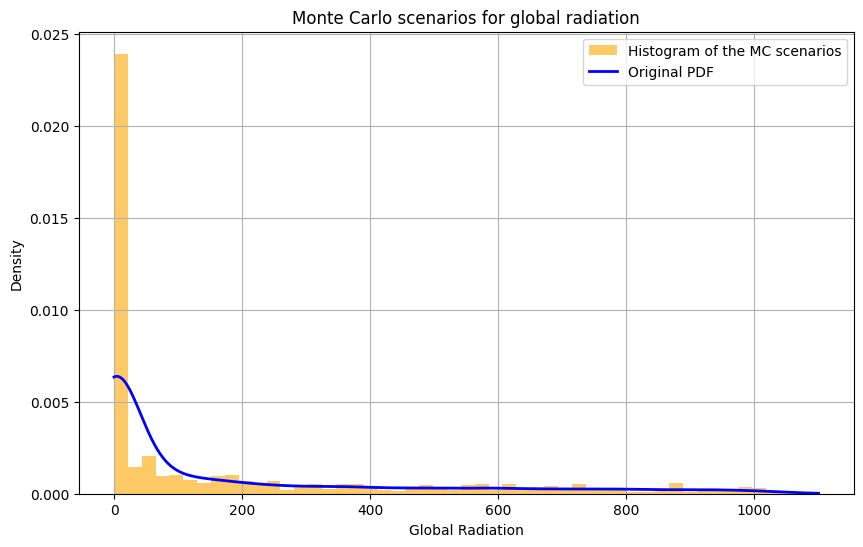

In [26]:
# Anzahl der zu generierenden Szenarien
n_samples = 1000

# Erzeuge gleichverteilte Zufallszahlen zwischen 0 und 1
uniform_samples = np.random.uniform(0, 1, n_samples)

# Nutze np.interp zur Interpolation der Quantile (inverse CDF)
mc_scenarios = np.interp(uniform_samples, cdf_values, sorted_data)

# Visualisierung der generierten Szenarien
plt.figure(figsize=(10, 6))
plt.hist(mc_scenarios, bins=50, density=True, alpha=0.6, label='Histogram of the MC scenarios', color='orange')
plt.plot(x_values, pdf_values, label='Original PDF', color='blue', linewidth=2)
plt.title('Monte Carlo scenarios for global radiation')
plt.xlabel('Global Radiation')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

## 5. scenario reduction using k-means clustering

The 1000 generated scenarios are grouped into 12 clusters using the k-Means algorithm. The cluster centers serve as representative scenarios, and the probabilities are derived from the cluster sizes.

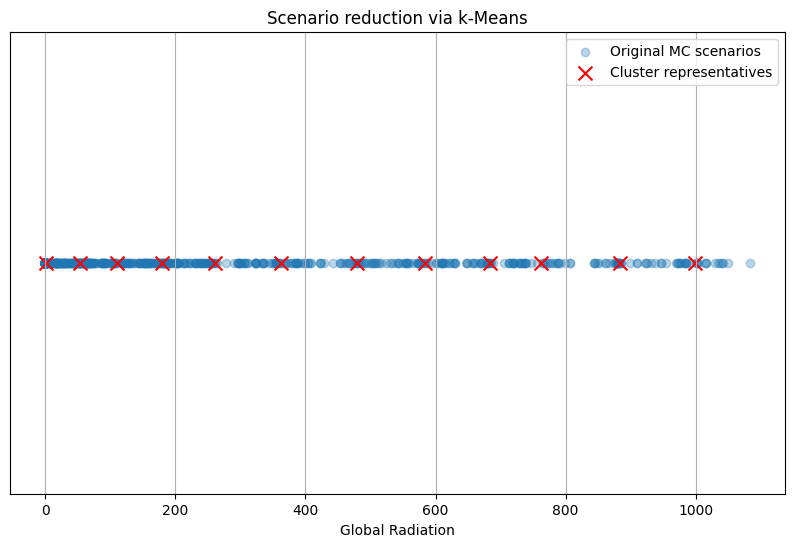

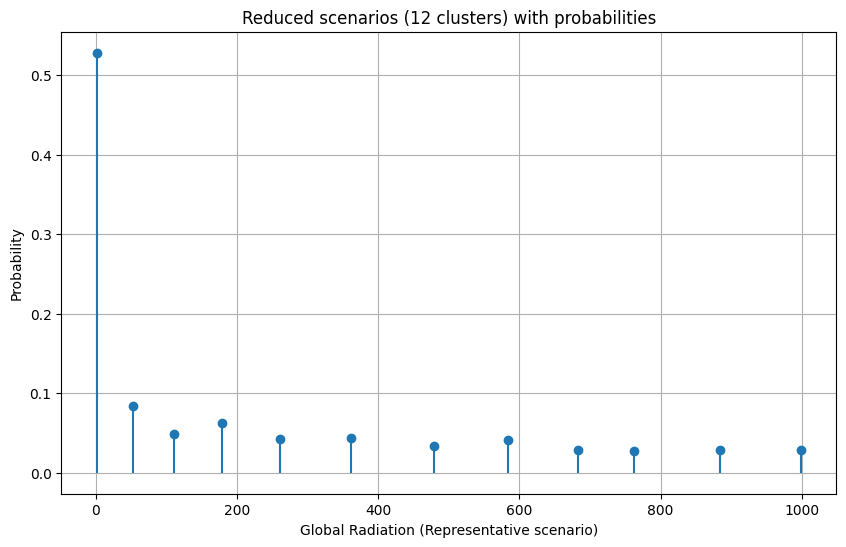

In [27]:
# Anzahl der ursprünglichen Szenarien und gleiche Wahrscheinlichkeit
num_scenarios = len(mc_scenarios)
original_prob = 1.0 / num_scenarios  # Alle Szenarien haben die gleiche Wahrscheinlichkeit

# Bestimme, wie viele Cluster (k) gewünscht sind
k = 12  # Beispiel: 12 repräsentative Szenarien

# KMeans-Clustering (KMeans erwartet 2D-Daten)
mc_scenarios_2d = mc_scenarios.reshape(-1, 1)
kmeans = KMeans(n_clusters=k, random_state=42).fit(mc_scenarios_2d)

# Cluster-Zuordnung und Clusterzentren
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_.flatten()

# Zähle, wie viele Szenarien pro Cluster fallen
unique, counts = np.unique(labels, return_counts=True)
counts_dict = dict(zip(unique, counts))

# Wahrscheinlichkeiten der Cluster berechnen
cluster_probs = [counts_dict[i] * original_prob for i in range(k)]

# Optional: Sortieren der Clusterzentren für eine übersichtliche Darstellung
sorted_indices = np.argsort(cluster_centers)
cluster_centers_sorted = cluster_centers[sorted_indices]
cluster_probs_sorted = np.array(cluster_probs)[sorted_indices]

# Visualisierung der Cluster und reduzierten Szenarien
plt.figure(figsize=(10, 6))

# (a) Scatter-Plot der ursprünglichen MC-Szenarien
plt.scatter(mc_scenarios, np.zeros_like(mc_scenarios),
            alpha=0.3, label='Original MC scenarios')

# (b) Plot der Clusterzentren als repräsentative Szenarien
plt.scatter(cluster_centers, np.zeros_like(cluster_centers),
            color='red', marker='x', s=100, label='Cluster representatives')

plt.title('Scenario reduction via k-Means')
plt.xlabel('Global Radiation')
plt.yticks([])  # y-Achse ausblenden, da es sich um 1D-Daten handelt
plt.legend()
plt.grid(True)
plt.show()

# Visualisierung der Wahrscheinlichkeitsverteilung der reduzierten Szenarien
plt.figure(figsize=(10, 6))
plt.stem(cluster_centers_sorted, cluster_probs_sorted, basefmt=' ')
plt.title('Reduced scenarios (12 clusters) with probabilities')
plt.xlabel('Global Radiation (Representative scenario)')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

## 6. extended cluster analysis: day of the year vs. global radiation

In this section, an additional column `day_of_year` (day of the year) is created and a 1D clustering of the global radiation data is performed. A scatter plot is then created showing the day of the year against the global radiation. The cluster centers are drawn as horizontal lines.

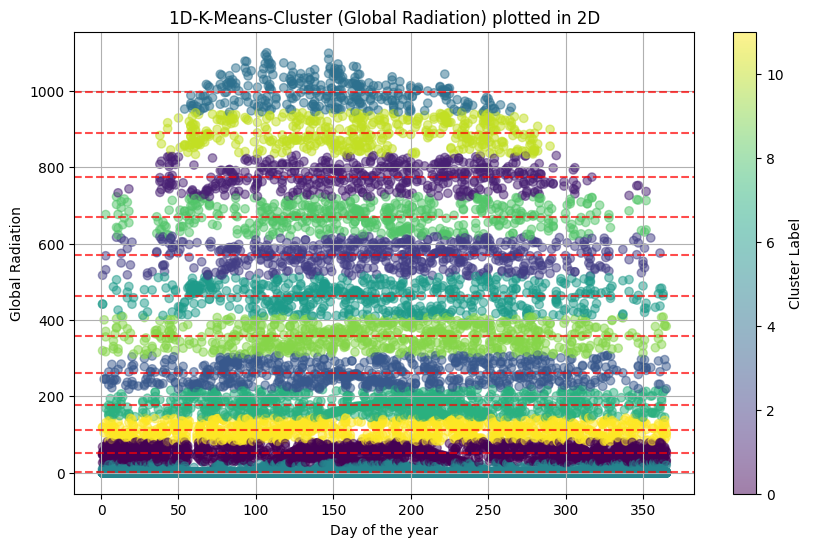

In [28]:
# Create the column 'day_of_year'
df['day_of_year'] = df['time'].dt.dayofyear

# Clustering based on global_radiation (1D)
X_1d = df['global_radiation'].values.reshape(-1, 1)
k = 12  # Number of clusters
kmeans_1d = KMeans(n_clusters=k, random_state=42)
labels_1d = kmeans_1d.fit_predict(X_1d)

# Scatter plot: Day of the year vs. global radiation
plt.figure(figsize=(10,6))
scatter = plt.scatter(
    df['day_of_year'],          # x-Achse
    df['global_radiation'],     # y-Achse
    c=labels_1d,                # Cluster-Labels als Farbe
    cmap='viridis',
    alpha=0.5
)
plt.colorbar(scatter, label='Cluster Label')
plt.xlabel('Day of the year')
plt.ylabel('Global Radiation')
plt.title('1D-K-Means-Cluster (Global Radiation) plotted in 2D')
plt.grid(True)

# Display the cluster centers as horizontal lines
centers_1d = kmeans_1d.cluster_centers_.flatten()
for center in centers_1d:
    plt.axhline(center, color='red', linestyle='--', alpha=0.7)

plt.show()

## Save the representative scenarios for the lower-level problem


In [29]:

# Create a DataFrame with the representative scenarios (cluster centers) and their probabilities
scenario_data = pd.DataFrame({
    'scenario_id': range(1, k + 1),
    'global_radiation': cluster_centers_sorted,
    'probability': cluster_probs_sorted
})

# Save the data in a CSV file
scenario_data.to_csv('representative_scenarios.csv', index=False)
print("The representative scenarios were saved in 'representative_scenarios.csv'.")


The representative scenarios were saved in 'representative_scenarios.csv'.
